## Import required libraries

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import gc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer
from imblearn.combine import SMOTEENN

## Jupyter Notebook Customization Output

In [2]:
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
pd.options.display.float_format = '{:.4f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

default_color = '#56B4E9'
colormap = plt.cm.cool

## Data Reading and Wrangling

In [3]:
# Set data directory
path_to_data = "./2007Q2/"

In [4]:
# Set columns' names
col_acq = ['LoanID','Channel','SellerName','OriginalInterestRate','OriginalUnpaidPrinc','OriginalLoanTerm',
        'OriginalDate','FirstPayment','OriginalLTV','OriginalCLTV','NumBorrowers','DTIRatio','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'ZIP','MortInsurancePerc','ProductType','CoCreditScore','MortInsuranceType','RelocationMortgageIndicator'];

col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
          'FPWA','ServicingIndicator'];

# Read the mortgage data as of acquisition date
data_acq = pd.read_csv(path_to_data + 'Acquisition_2007Q2.txt', 
                       sep='|', 
                       names=col_acq, 
                       index_col="LoanID")

# Read Loan ID, Month Reporting Date, and ForeclosureDate, which we will use as a proxy for default
data_per = pd.read_csv(path_to_data + 'Performance_2007Q2.txt', 
                       sep='|', names=col_per, 
                       usecols=[0, 1, 15], 
                       index_col=False)

gc.collect()

0

In [5]:
def custom_to_date(date_column, date_format="%m/%d/%Y"):
    """
    Parse date type columns more efficiently
    :param s: pandas.Series
    
    :return: pandas.Series
    """
    
    dates = {date:pd.to_datetime(date, format=date_format) for date in date_column.unique()}
    return date_column.map(dates)

In [6]:
# The Performance file contains multiple entries for the same Loan, because it records the loan performance
# for every payment period. Since we need the last record for each loan, we order the data by the
# Reporting Date (MonthRep) and then drop any duplicate records except for the last one

data_per["MonthRep"] = custom_to_date(data_per['MonthRep'])
data_per = data_per.set_index(["LoanID", "MonthRep"]).sort_index(axis=0, level=["LoanID", "MonthRep"]).reset_index()
data_per.drop_duplicates(subset='LoanID', keep='last', inplace=True)
data_per.set_index(["LoanID"], inplace=True)
data_per.drop("MonthRep", axis=1, inplace=True)

In [7]:
# Merge Acquisition dataframe and Performance dataframe on LoanID
loan_data = pd.merge(data_acq, data_per, left_index=True, right_index=True)

In [8]:
# Use ForeclosureDate column as proxy for Defaulting
loan_data.rename(columns={"ForeclosureDate": 'Default'}, inplace=True)
loan_data['Default'].fillna(0, inplace=True)
loan_data.loc[loan_data['Default'] != 0, 'Default'] = 1
loan_data['Default'] = loan_data['Default'].astype(int)

## Data Exploration

In [9]:
loan_data.dtypes

Channel                         object
SellerName                      object
OriginalInterestRate           float64
OriginalUnpaidPrinc              int64
OriginalLoanTerm                 int64
OriginalDate                    object
FirstPayment                    object
OriginalLTV                      int64
OriginalCLTV                   float64
NumBorrowers                   float64
DTIRatio                       float64
CreditScore                    float64
FTHomeBuyer                     object
LoanPurpose                     object
PropertyType                    object
NumUnits                         int64
OccStatus                       object
PropertyState                   object
ZIP                              int64
MortInsurancePerc              float64
ProductType                     object
CoCreditScore                  float64
MortInsuranceType              float64
RelocationMortgageIndicator     object
Default                          int64
dtype: object

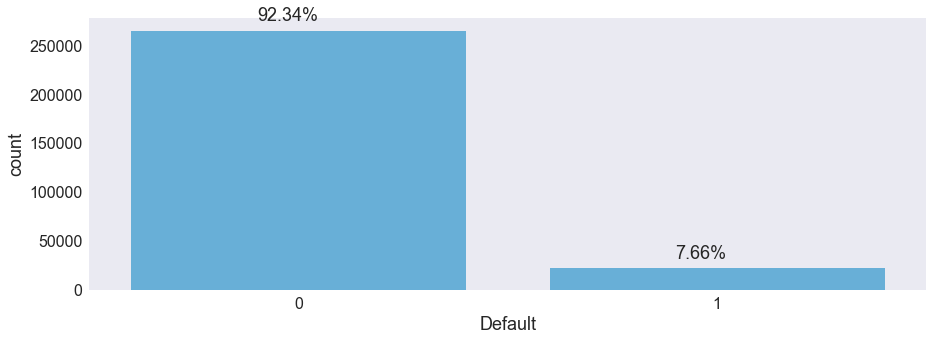

In [10]:
# Number of Defaulted Loans
plt.figure(figsize=(15,5))

ax = sns.countplot('Default', data=loan_data, color=default_color)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(loan_data['Default'])), (p.get_x()+ 0.3, p.get_height()+10000))
    
plt.savefig('ImbalancedDataset.png')

From the plot above, it is clear we are dealing with an imbalanced dataset (when the number of observations in one class is much larger than those belonging to other classes). This behavior was alreasy expected, since loan default prediction belongs a class of problems we can call **Anomaly Detection**. Belonging to this class, we also have identification of diseases ans fraudulent transactions in banks.

In this situation, if we do not take any precation measures, our model might be biased and inaccurate. We describe later how we will deal with this problem.

### Possible Important Features

Let's look at the most important features when we analyse loan's characteristics
- **OriginalLTV**: The loan-to-value ratio is a financial term used by lenders to express the ratio of a loan to the value of an asset purchased. The higher the LTV ratio, the riskier is the loan;
- **DTIRatio**: The debt-to-income ratio is the percentage of a consumer's monthly gross income that goes toward paying debts. The higher the DTI ratio, the riskier is the loan;
- **CreditScore**: The borrower credit score at the time of the loan acquisition by Fannie Mae;
- **OriginalInterestRate**: The loan interest rate.

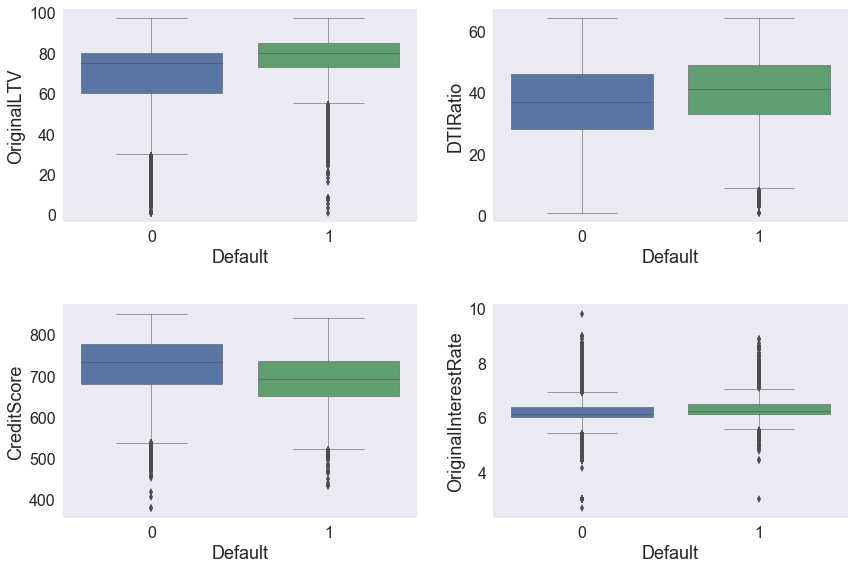

In [11]:
columns = ['OriginalLTV','DTIRatio','CreditScore','OriginalInterestRate']

fig, axes = plt.subplots(nrows=2, ncols=2)
plt.tight_layout(w_pad=2.0, h_pad=3.0)

for i, column in zip(range(1, 5), columns):
    plt.subplot(2, 2, i)
    sns.boxplot(x="Default", y=column, data=loan_data, linewidth=0.5)
    plt.xlabel("Default")

The boxplots above show that our intuition was correct. Defaulters have, on average, higher Loan-to-Value ratio, higher Debt-to-Income ratio, lower Credit Score at the time of the loan acquisition. Interestingly, the interest rate boxplot indicates that the loan rate might not have a preditive power over which loan will defaulted.

Text(0,0.5,'ZIP Code')

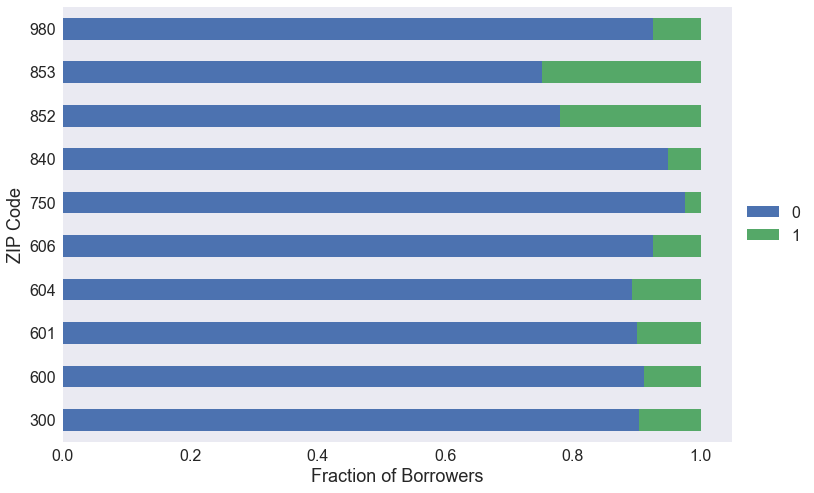

In [12]:
# Get the loans that have ZIP code equal to the ten most common ZIP codes
loan_zip_10 = loan_data.loc[loan_data['ZIP'].isin(loan_data['ZIP'].value_counts().index.tolist()[:10])]

# Counts loans by ZIP and Default
xtab = pd.pivot_table(loan_zip_10, index='ZIP', columns='Default', aggfunc='size')
# % of Loans by ZIP and Default
xtab = xtab.div(xtab.sum(axis=1), axis=0)

# Plot
xtab.plot.barh(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Fraction of Borrowers')
plt.ylabel('ZIP Code')

From the plot above, we see important differences in the proportion of defaulters by ZIP Code. Thus, indicating the ZIP Code feature might be a significant factor when predicting whether a loan will default. 

## Pre-Processing

In [13]:
# Split OriginalDate and FirstPayment features into their month and year,
# in case, these might have some predictive power

loan_data['OriginalMonth'] = loan_data['OriginalDate'].apply(lambda x: x.split('/')[0].strip()).astype(int)
loan_data['OriginalYear'] = loan_data['OriginalDate'].apply(lambda x: x.split('/')[1].strip()).astype(int)

loan_data['FirstMonth'] = loan_data['FirstPayment'].apply(lambda x: x.split('/')[0].strip()).astype(int)
loan_data['FirstYear'] = loan_data['FirstPayment'].apply(lambda x: x.split('/')[1].strip()).astype(int)

loan_data.drop(['OriginalDate','FirstPayment'], axis=1, inplace=True)

gc.collect()

271

### Missing Values and Categorical Features

In [14]:
missingValueColumns = loan_data.columns[loan_data.isnull().any()].tolist()
loan_data_null = loan_data[missingValueColumns] 

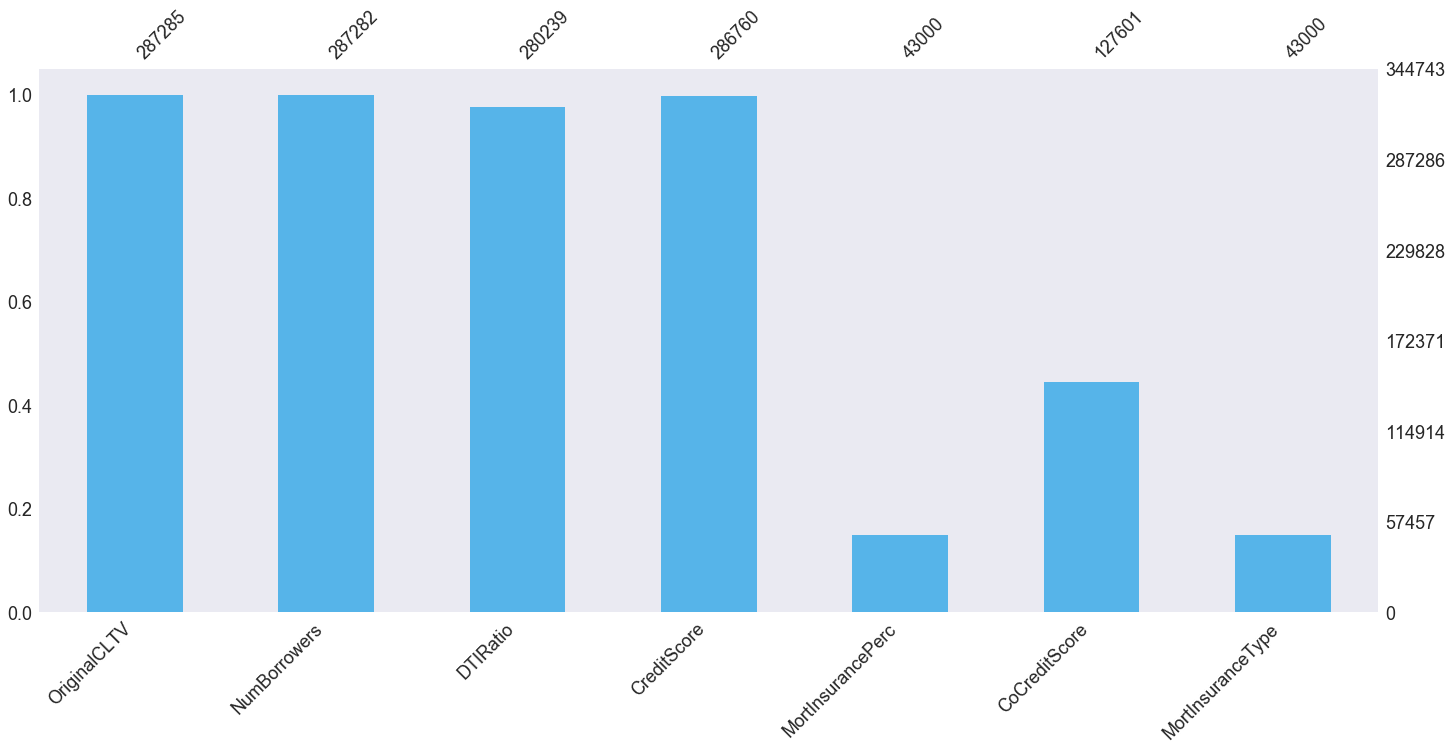

In [15]:
msno.bar(loan_data_null, color=default_color, fontsize=18, labels=True)

In [16]:
# With large number of missing values, we will drop the MortInsurancePerc, the CoCreditScore, and the MortInsuranceType.
# Also, we will drop the LoanID and the ProductType, because it has just one value

loan_data.drop(["MortInsurancePerc", "CoCreditScore", "MortInsuranceType", "ProductType"], 
               axis=1, 
               inplace=True)

In [17]:
def label_encoding(data):
    """
    Encode labels for categorical features
    :param data: pandas.DataFrame
    
    :return: pandas.DataFrame
    """
    
    categorical_columns = data.select_dtypes(include=['object'])
    for column in categorical_columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        
    return data

In [18]:
def fill_missing_values(data):
    """
    Fill missing values using a Random Florest Regressor
    
    :param data: pandas.DataFrame
    
    :return: pandas.DataFrame
    """
    with_nan_columns = data.columns[data.isnull().any()]
    for column in with_nan_columns:
        print(column)
        y_notnull = data.loc[data[column].notnull(), column].values
        X_notnull = data.loc[data[column].notnull()].drop(with_nan_columns, axis=1).values
        X_null = data.loc[data[column].isnull()].drop(with_nan_columns, axis=1).values
        model = RandomForestRegressor(n_estimators=400, max_depth=3)
        model.fit(X_notnull, y_notnull)
        data.loc[data[column].isnull(), column] = model.predict(X_null)
    
    return data

In [19]:
gc.collect()
loan_data = label_encoding(loan_data)
loan_data = fill_missing_values(loan_data)

OriginalCLTV
NumBorrowers
DTIRatio
CreditScore


In [20]:
loan_data.columns
gc.collect()

33

### Dealing with the Imbalanced Dataset

In [21]:
# In order to deal with our imbalanced dataset, 
# we will apply a technique called SMOTE: Synthetic Minority Over-sampling Technique.
# It was introduced in 2002 (https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html)
# and it works by interpolating new instances from the existing ones of the minority class.

sm = SMOTEENN()

y = loan_data['Default'].values
X = loan_data.drop(['Default'], axis=1).values

X_resampled, y_resampled = sm.fit_sample(X, y)

## The Baseline model - Decision Tree Classifier

In [22]:
gc.collect()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
predict = clf.predict(X_test)

### Model Evaluation

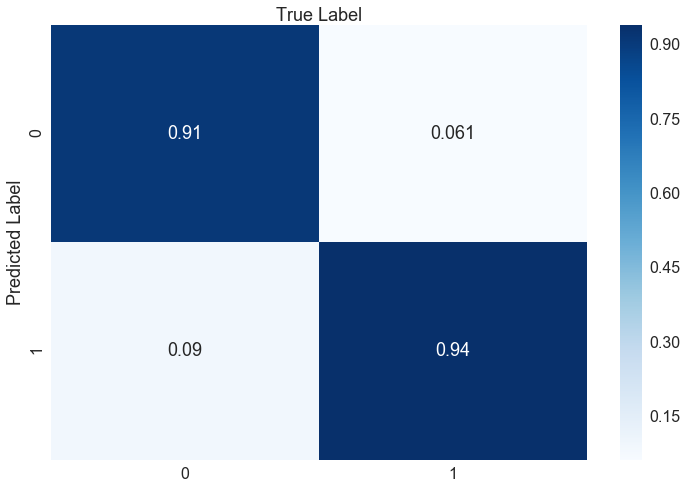

In [23]:
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

From the confusion matrix above, we see the model predict correctly 98% (true negatives) of all non-defaulters and 95% (true positives) of the defaulters. In term of importance for Fannie Mae, the number of false negatives is an important metric, since Fannie Mae profitabily is affected when a defaulter is misclassified. In our case, false negatives were approximately 5% of all defaulters.

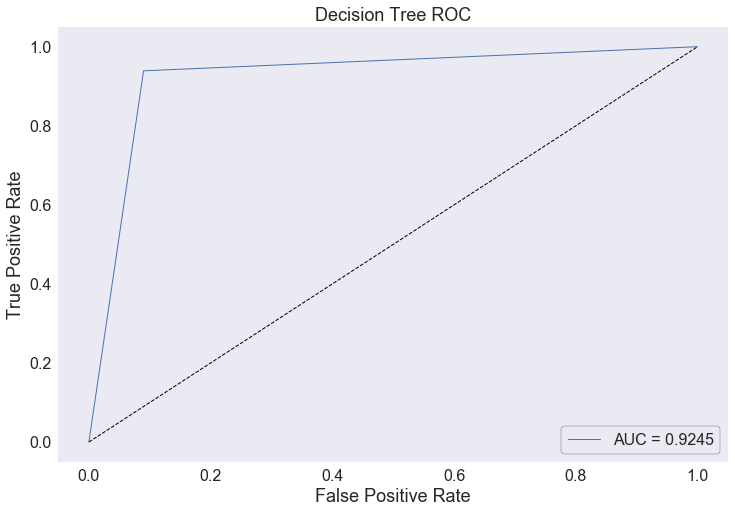

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.4f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

The ROC curve (receiver operating characteristics) shows the number of true positives vs. the number of false positives labeled by the algorithm for a number of classification threshold values.

In the case of a perfect classifier, the area-under-the-curve (AUC) would be 1. The black dashed curve represents a random classifier (with no predicitive power) and has AUC equal to 0.5.

In our case, it is clear that the model model has a great predictive power with AUC = 0.96.

## Random Forest Classifier

In [25]:
gc.collect()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state=42)

clfRF = RandomForestClassifier(n_estimators=20, min_samples_leaf=1, max_features="sqrt", random_state=42)
clfRF.fit(X_train, y_train)
predictRF = clfRF.predict(X_test)

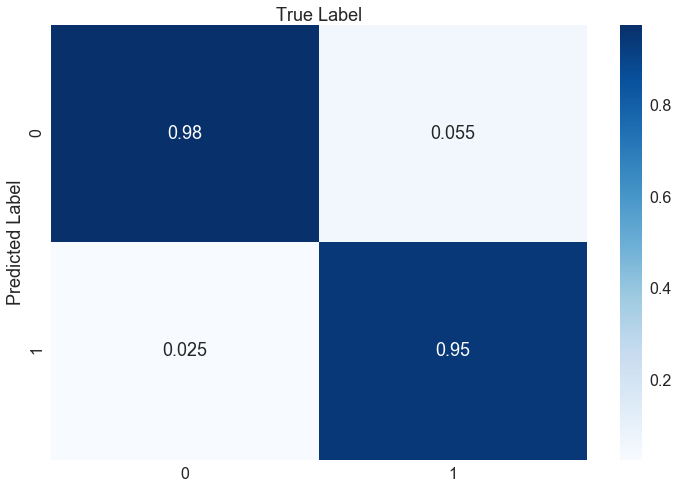

In [26]:
## Model Evaluation
cm = confusion_matrix(y_test, predictRF).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

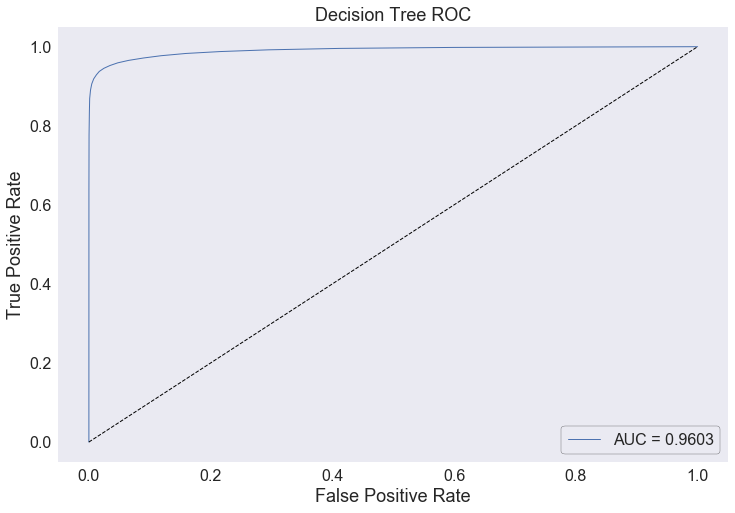

In [27]:
## ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, clfRF.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predictRF)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.4f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

## Parameter Tuning - Grid Search

In [28]:
gc.collect()
parameters = {"n_estimators": [20, 40] , "min_samples_leaf": [1, 5] , "max_features": ["sqrt", "log2"]}
rf = RandomForestClassifier()
clf_tuned = GridSearchCV(rf, parameters)

clf_tuned.fit(X_train, y_train)
tuned_prediction = clf_tuned.predict(X_test)

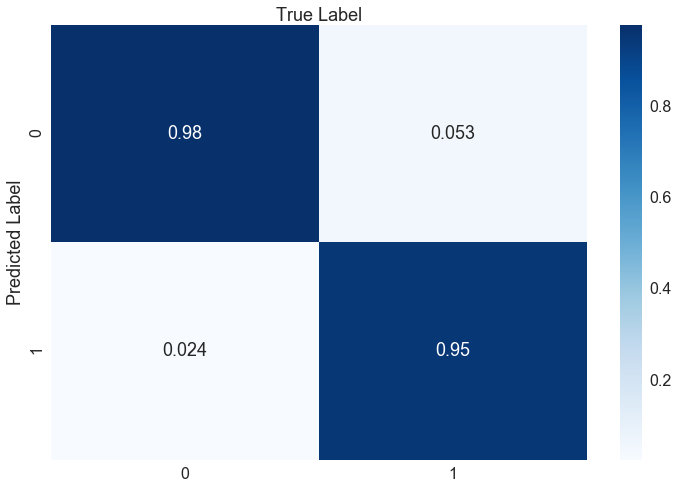

In [29]:
## Model Evaluation
cm = confusion_matrix(y_test, tuned_prediction).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

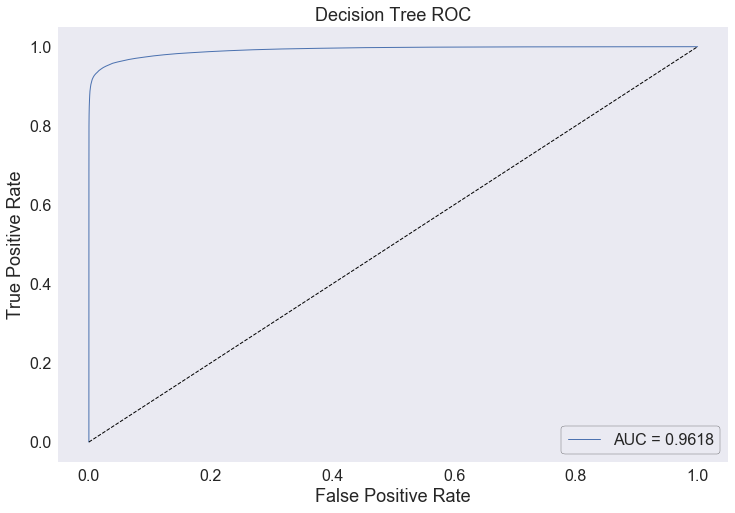

In [30]:
## ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, clf_tuned.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, tuned_prediction)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.4f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

In [ ]:
roc_scorer = make_scorer(roc_auc_score)

roc_scores = cross_val_score(estimator=clf_tuned, X=X_resampled, y=y_resampled, scoring=roc_scorer, cv=5)

print(roc_scores)

### Features with the most predictive power

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

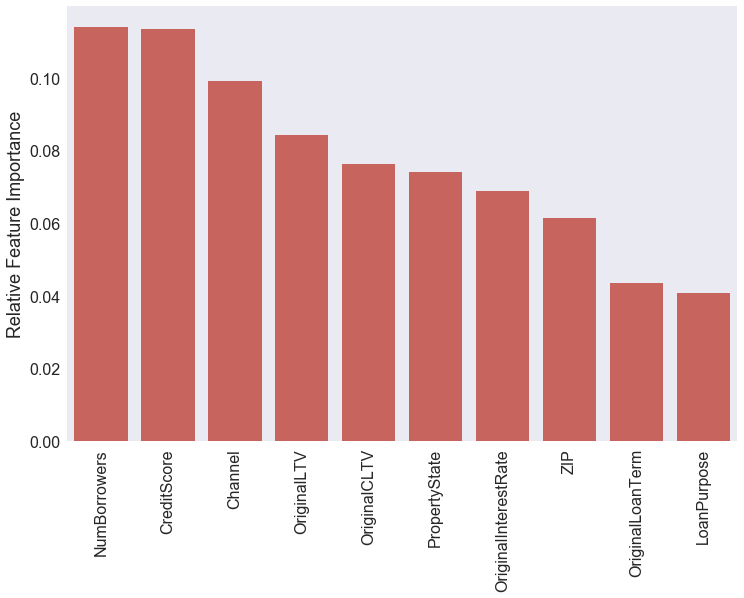

In [36]:
feat_labels = loan_data.drop('Default', axis=1).columns
importances = clfRF.feature_importances_
indices = np.argsort(importances)[::-1]

ncomp = 10
sns.barplot(x=feat_labels[indices[:ncomp]], y=importances[indices[:ncomp]], color=sns.xkcd_rgb["pale red"])
plt.ylabel('Relative Feature Importance')
plt.xticks(rotation=90)

From all features, apparently, CreditScore, Number of Borrowers and Loan-to-Value ratio appear to have the most predictive power.

In [42]:
gc.collect()
parameters = {"n_estimators": [20, 40] , "min_samples_leaf": [1, 5] , "max_features": ["sqrt", "log2"]}
rf = RandomForestClassifier()
clf_tuned = GridSearchCV(rf, parameters)

clf_tuned.fit(X_train[:, indices[0:10]], y_train)
tuned_prediction = clf_tuned.predict(X_test[:, indices[0:10]])

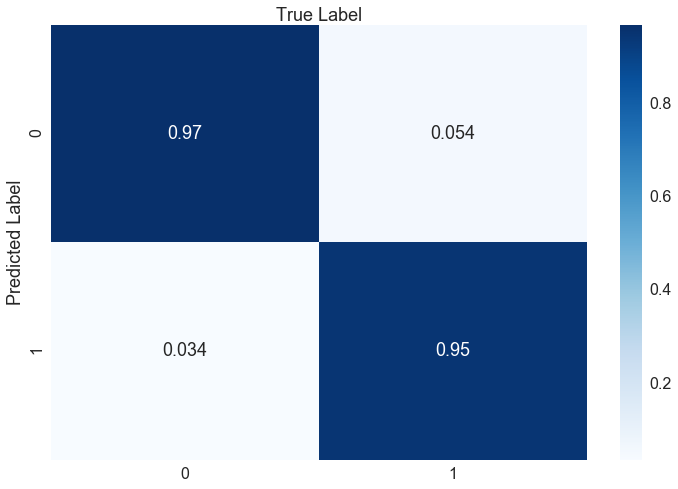

In [43]:
## Model Evaluation
cm = confusion_matrix(y_test, tuned_prediction).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

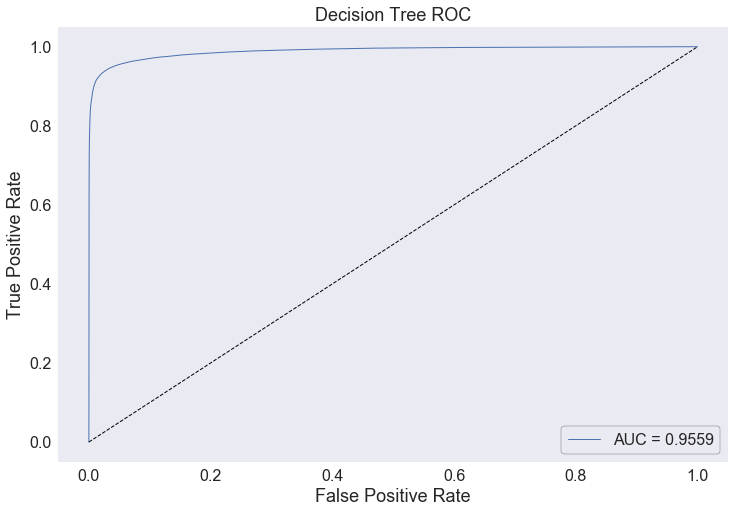

In [45]:
## ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, clf_tuned.predict_proba(X_test[:, indices[0:10]])[:,1])
roc_auc = roc_auc_score(y_test, tuned_prediction)

plt.plot(fpr, tpr, lw=1, label='AUC = %0.4f'%(roc_auc))
plt.plot([0, 1], [0, 1], '--k', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC')
plt.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

In [41]:
X_train[:, indices[0:10]].shape

(313654, 10)